# Load nutrient data

1. make x-array
2. combine good data
3. create plot with one y axis µM and the other pressure
    -> only select pressure for sampling days

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime 
from datetime import date
import xarray as xr
import pandas as pd
import marineHeatWaves as mhw

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# for pressure time series
file_name = "data/rteb_all_1D.nc"
ds_eb = xr.open_dataset(file_name)

In [4]:
# for MHWs and MCSs in the plot
file_name = "data/Rockall-Trough-Mooring-Time-Series-2020.nc"
ds = xr.open_dataset(file_name)

ds.coords['DEPTH'] = ds.PRES
ds = ds[['TG_EAST', 'TG_WEST']]

# for TG_EAST
ds['TG_EAST_C'] = ds.TG_EAST-273.15
ds.TG_EAST_C.attrs = ds.TG_EAST.attrs 
ds.TG_EAST_C.attrs['units'] = 'degC'
ds.TG_EAST_C.attrs

# and TG_WEST
ds['TG_WEST_C'] = ds.TG_WEST-273.15
ds.TG_WEST_C.attrs = ds.TG_WEST.attrs 
ds.TG_WEST_C.attrs['units'] = 'degC'
ds.TG_WEST_C.attrs;

ds1D = ds.resample(TIME = "1D").mean(keep_attrs=True); 

In [5]:
file_name = '/Users/marie-louisekorte/OneDrive - University of the Highlands and Islands/SAMS Summer Internship/Rockall_Trough_MHW/data/BioGeoChem/20172018_RAS_data_use_original.csv'
pd_N = pd.read_csv(file_name, header = 10)
pd_N = pd_N.drop(labels = 0)

# Functions

In [6]:
def MHW_func (data, depth, climP=[2014.0,2020.0], altClim=False):
    yy_start = int(data.TIME[0].dt.year)
    yy_end = int(data.TIME[-1].dt.year)
    mm_start = int(data.TIME[0].dt.month)
    mm_end = int(data.TIME[-1].dt.month)
    dd_start = int(data.TIME[0].dt.day)
    dd_end = int(data.TIME[-1].dt.day)
    
    t = np.arange(
        datetime.date(yy_start, mm_start, dd_start).toordinal(),                 # .toordinal turns the date into a number that the algorithm can process
        datetime.date(yy_end, mm_end, dd_end).toordinal()+1,1) 
    
    temp = data.sel(DEPTH=depth, method = 'nearest').squeeze().values   # by using .squeeze().values we are first removing any other depth and then turning the data into a 1d numpy array 
                                                                        # without doing this the data will still be in an array and the algorithm can't handle it
    
    mhws, clim = mhw.detect(t, temp, climatologyPeriod=climP, alternateClimatology=altClim)                                    # using the algorithm
    mcss, clim_cold = mhw.detect(t, temp, coldSpells = True, climatologyPeriod=climP, alternateClimatology=altClim)            # cold spells 
    return mhws, mcss, clim, clim_cold, t, temp

In [7]:
def DICT_func(data, depth, climP=[2014,2020], altClim= False, altT=False, altData=False):  
    # define 6 empty dictionaries
    mhws_,mcss_,clim_,clim_cold_,t_,temp_ = {},{},{},{},{},{}

    # Iterating through all instrument depths       
    for n in depth:
        
        if altClim:
            temp_oras = np.array(altData.sel(DEPTH=n, method= 'nearest'))
            altClim=[altT,temp_oras]

        mhws, mcss, clim, clim_cold, t, temp = MHW_func(data, n, climP=climP, altClim=altClim)
        mhws_.update({str(n):mhws})
        mcss_.update({str(n):mcss})
        clim_.update({str(n):clim})
        clim_cold_.update({str(n):clim_cold})
        t_.update({str(n):t})
        temp_.update({str(n):temp})
    
    dictionary = {'mhws':mhws_,'mcss':mcss_,'clim':clim_,'clim_cold':clim_cold_,'t':t_,'temp':temp_}
    return dictionary

In [47]:
def OV_stacked_ax_events(dict, n, ax):
    
    #defining my variables
    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]
    
    ev = (mhws['n_events'])
    ec = (mcss['n_events'])

    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        
        ax.axvspan(xmin=dates[t1], xmax=dates[t2],color='deeppink', alpha=0.3)
        

    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        
        ax.axvspan(xmin=dates[tc1], xmax=dates[tc2],color='darkcyan', alpha=0.3)

    ;
    

# Format Panda df and make ds

In [9]:
pd_N['time']=''

In [10]:
dt_year = (pd_N.Year) 
dt_month =(pd_N.Month)
dt_day = (pd_N.Day)
#dt_hour = (pd_N.Hour)

In [11]:
dt_all = (dt_year + dt_month + dt_day) # + dt_hour)

In [12]:
format= "%Y%m%d" #%H"

In [13]:
for n in dt_all.index:
    dt_object = datetime.datetime.strptime(dt_all[n], format)
    pd_N.time[n]=dt_object

In [14]:
pd_N

,Sample id,Day,Month,Year,Hour,Min,Nitrite1,Nitrite2,Nitrite+Nitrate1,Nitrite+Nitrate2,...,Phosphate2,Phos1_flag,Phos2_flag,mean DIC,std DIC,DIC_flag,mean TA,std TA,TA_flag,time
1,RAS 1,15,5,2017,6,0,0.1,0.2,8.6,5.3,...,0.69,3,2,2865,3,4,2313,4,2,2017-05-15 00:00:00
2,RAS 2,25,5,2017,6,0,0.2,0.2,9.5,9.2,...,0.85,3,2,2883,7,4,2275,8,4,2017-05-25 00:00:00
3,RAS 3,4,6,2017,6,0,0.0,0.0,9.2,10.3,...,0.88,2,2,2894,10,4,2321,0,2,2017-06-04 00:00:00
4,RAS 4,14,6,2017,6,0,0.1,0.1,3.2,3.2,...,0.60,2,2,2686,2,4,2179,3,4,2017-06-14 00:00:00
5,RAS 5,24,6,2017,6,0,0.0,0.3,10.9,6.9,...,0.77,3,2,2856,6,4,2316,2,2,2017-06-24 00:00:00
6,RAS 6,4,7,2017,6,0,0.2,0.2,6.4,6.5,...,0.66,2,2,2148,7,4,1780,85,4,2017-07-04 00:00:00
7,RAS 7,14,7,2017,6,0,0.2,0.3,6.2,8.2,...,0.84,2,2,2964,6,4,2320,7,2,2017-07-14 00:00:00
8,RAS 8,24,7,2017,6,0,0.3,0.3,7.4,7.5,...,0.76,2,2,2581,5,4,2077,7,4,2017-07-24 00:00:00
9,RAS 9,3,8,2017,6,0,0.0,0.4,10.8,8.0,...,0.84,2,2,2994,6,4,2319,2,2,2017-08-03 00:00:00
10,RAS 10,13,8,2017,6,0,0.2,0.2,4.9,5.2,...,0.61,2,2,2871,3,4,2313,6,2,2017-08-13 00:00:00


In [15]:
ds_N = pd_N.to_xarray()

In [16]:
ds_N.coords['time'] = ds_N.time
ds_N = ds_N.swap_dims({'index':'time'}).drop('index')
ds_N.time.attrs['units'] = 'days since 1950-01-01 00:00:00'

In [17]:
ds_N = ds_N.drop_vars('Sample id')
ds_N = ds_N.astype(float)
ds_N

<xarray.Dataset>
Dimensions:           (time: 42)
Coordinates:
  * time              (time) datetime64[ns] 2017-05-15 2017-05-25 ... 2018-06-29
Data variables: (12/27)
    Day               (time) float64 15.0 25.0 4.0 14.0 ... 30.0 9.0 19.0 29.0
    Month             (time) float64 5.0 5.0 6.0 6.0 6.0 ... 5.0 5.0 6.0 6.0 6.0
    Year              (time) float64 2.017e+03 2.017e+03 ... 2.018e+03 2.018e+03
    Hour              (time) float64 6.0 6.0 6.0 6.0 6.0 ... 6.0 6.0 6.0 6.0 6.0
    Min               (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Nitrite1          (time) float64 0.1 0.2 0.0 0.1 0.0 ... 0.2 0.2 0.3 0.3 0.2
    ...                ...
    mean DIC          (time) float64 2.865e+03 2.883e+03 ... 2.582e+03 1.945e+03
    std DIC           (time) float64 3.0 7.0 10.0 2.0 6.0 ... 4.0 6.0 14.0 273.0
    DIC_flag          (time) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0 4.0
    mean TA           (time) float64 2.313e+03 2.275e+03 ... 2.322e+03 1.3e+03
    std TA            (time) float64 4.0 8.0 0.0 3.0 2.0 ... 1.0 13.0 10.0 nan
    TA_flag           (time) float64 2.0 4.0 2.0 4.0 2.0 ... 2.0 2.0 4.0 2.0 4.0

# Select and combine good data

In [18]:
def combine_good(ds_1, ds_2, flag_1, flag_2):
    N1 = ds_1.where(flag_1==2)
    N2 = ds_2.where(flag_2==2)
    N = xr.concat([N1, N2], dim = 'sample')
    N = N.mean('sample', keep_attrs=True)
    
    return N

In [19]:
N = combine_good(ds_N['Nitrite+Nitrate1'], ds_N['Nitrite+Nitrate2'], ds_N.Nit1_flag, ds_N.Nit2_flag)
S = combine_good(ds_N['Silicate1'], ds_N['Silicate2'], ds_N.Silc1_flag, ds_N.Silc2_flag)
P = combine_good(ds_N['Phosphate1'], ds_N['Phosphate2'], ds_N.Phos1_flag, ds_N.Phos2_flag)

ds_Nutr = xr.merge([N,S,P])

In [20]:
ds_Nutr = ds_Nutr.rename_vars({'Nitrite+Nitrate1':'NitriteNitrate',
                               'Silicate1':'Silicate', 
                               'Phosphate1':'Phosphate'})

In [21]:
ds_Nutr['pres'] = ds_eb.pres.sel(depth=50).where(ds_Nutr.time.notnull())

In [22]:
ds_Nutr

<xarray.Dataset>
Dimensions:         (time: 42)
Coordinates:
  * time            (time) datetime64[ns] 2017-05-15 2017-05-25 ... 2018-06-29
    depth           float64 50.0
Data variables:
    NitriteNitrate  (time) float64 5.3 nan nan nan 6.9 ... 7.9 8.15 8.65 6.85
    Silicate        (time) float64 1.0 nan nan 0.75 1.4 ... 1.45 1.5 1.55 0.95
    Phosphate       (time) float64 0.69 0.85 0.775 0.585 ... 0.875 0.92 0.72
    pres            (time) float64 61.26 56.13 56.91 56.7 ... 55.62 55.3 54.99

# Plot

In [23]:
# creat dictionary so I can plot with my existing functions 
# not correcting 100m 2016/2017 data becuase I am only looking at 50m data here

depth_EB = np.array(ds_eb.depth).astype(int)
EAST = DICT_func(ds1D.TG_EAST_C, depth_EB)

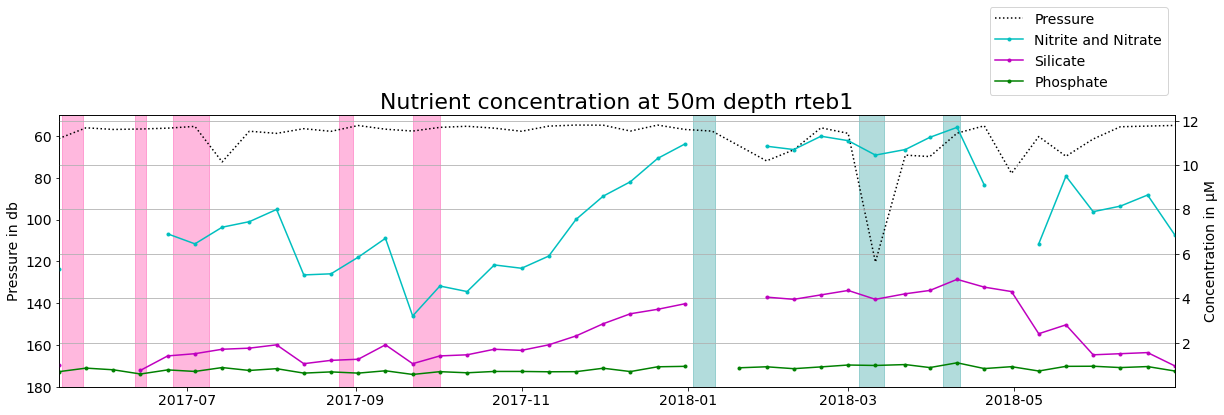

In [66]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
ax2 = ax.twinx()

ax.plot(ds_Nutr.time, ds_Nutr.pres, 'k:', label = 'Pressure');
ax.set_ylim(180,50)
ax.set_ylabel('Pressure in db');

OV_stacked_ax_events(EAST, 50, ax)
ax.set_xlim(ds_Nutr.time[0],ds_Nutr.time[-1])

ax2.plot(ds_Nutr.time, ds_Nutr.NitriteNitrate, 'c.-', label = 'Nitrite and Nitrate')
ax2.plot(ds_Nutr.time, ds_Nutr.Silicate, 'm.-', label = 'Silicate')
ax2.plot(ds_Nutr.time, ds_Nutr.Phosphate, 'g.-', label = 'Phosphate') 
ax2.grid()
ax2.set_ylabel('Concentration in µM');#
ax2.set_xlabel('');
ax2.set_title('Nutrient concentration at 50m depth rteb1');

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=22) #fontsize of the title

fig.legend(bbox_to_anchor=(0.9, 1.2))
#fig.legend();
#fig.tight_layout()

fig.savefig('figures/Nutrients_and_Pressure', dpi = 300,  bbox_inches='tight')


In [25]:
font = {'weight' : 'normal','size' : 14}
plt.rc('font', **font)